In [7]:
#%load_ext tensorboard
import btk
import dataset_generators as dgen
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from PIL import Image
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

chars = 'abcdefghijklmnopqrstuvwxyzABDEFGHIJKLMNQRTUY0123456789 ():;.,"\'!@#$%&?+=-'
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(f"{os.environ['style']}")

In [ ]:
""" trainx_1, trainy_1, valx_1, valy_1 = btk.depickler('trainx-1645088683', 'trainy-1645088683', 'valx-1645088683', 'valy-1645088683', 'ocr')
trainx_2, trainy_2, valx_2, valy_2 = btk.depickler('trainx-1645089083', 'trainy-1645089083', 'valx-1645089083', 'valy-1645089083', 'ocr')
trainx_3, trainy_3, valx_3, valy_3 = btk.depickler('trainx-1645094146', 'trainy-1645094146', 'valx-1645094146', 'valy-1645094146', 'ocr')
trainx_4, trainy_4, valx_4, valy_4 = btk.depickler('trainx-1645089563', 'trainy-1645089563', 'valx-1645089563', 'valy-1645089563', 'ocr')
trainx_5, trainy_5, valx_5, valy_5 = btk.depickler('trainx-1645094355', 'trainy-1645094355', 'valx-1645094355', 'valy-1645094355', 'ocr') """

""" trainx, trainy = dgen.gen_tcls_data(165000, dgen.xtcls, dgen.trainfonts, False, dgen.chars)
valx, valy = dgen.gen_tcls_data(55000, dgen.xtcls, dgen.evalfonts, False, dgen.chars)
display(btk.pickle_set(trainx, trainy, valx, valy, 'ocr')) """

In [ ]:
#Data generator and data set verification
""" num = random.randint(0, 160000)
for i, x in enumerate(trainx[num:num + 5]):
    display(Image.fromarray(x))
    display(dgen.chars_cased[trainy[i + num].argmax()]) """

""" tx, ty = dgen.gen_tcls_data(10, dgen.chars, dgen.evalfonts, True, dgen.chars)
for i, x in enumerate(tx):
    display(Image.fromarray(x))
    display(dgen.chars_cased[ty[i].argmax()]) """

In [5]:
def model_init():
    inp = keras.Input(shape=(64, 64, 1))
    x = layers.Rescaling(1.0/255)(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization(axis=3)(x)
    for features in [32, 64, 128, 256]:
        res = x
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)
        res = layers.Conv2D(features, 1, strides=2, activation='relu')(res)
        x = layers.add([x, res])
        x = layers.BatchNormalization(axis=3)(x)
        res = x
        x = layers.Conv2D(features, 1, activation='relu')(x)
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.add([x, res])
        x = layers.BatchNormalization(axis=3)(x)
        res = x
        x = layers.Conv2D(features, 1, activation='relu')(x)
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.add([x, res])
        x = layers.BatchNormalization(axis=3)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.3678)(x)
    outp = layers.Dense(73, activation='softmax')(x)

    opti = keras.optimizers.Adam(learning_rate=0.001)
    mod = keras.Model(inp, outp, name='text_class')
    mod.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return mod

tcls = model_init()
tcls.summary()

Model: "text_class"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 64, 64, 1)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 64, 64, 32)   320         ['rescaling_2[0][0]']            
                                                                                                  
 batch_normalization_38 (BatchN  (None, 64, 64, 32)  128         ['conv2d_46[0][0]']              
 ormalization)                                                                           

In [ ]:
#Model architecture testing
tnum = 0
measure = 'categorical_accuracy'
imgent = btk.DataGen(trainx_1, trainy_1, 192)
imgenv = btk.DataGen(valx_1, valy_1, 64)

for itr in range(2):
    log_dir = f"tblogs/classification/0/tcls0/"
    tbcall = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    tnum += 1
    tcls = model_init()
    tstart = time.time()
    history = tcls.fit(
        x = imgent,
        validation_data=imgenv,
        epochs=32,
        steps_per_epoch=32,
        validation_steps=32,
        callbacks=[tbcall],
        verbose=0
    )
    tstop = time.time()
    ttime = tstop - tstart
    if itr == 0:
        old_hist = history.history
        otime = ttime
    if itr == 1:
        btk.mlstats(history.history, measure, ttime, old_hist, otime)

In [6]:
#Training Loop
log_dir = "tblogs/classification/2/128F_2ID_4L_32E/"
metric = "categorical_accuracy"
best_score = 0.9
for i in range(11):
    if i in [0, 5, 10]:
        imgent = btk.DataGen(trainx_1, trainy_1, 192)
        imgenv = btk.DataGen(valx_1, valy_1, 64)
    elif i in [1, 6]:
        imgent = btk.DataGen(trainx_2, trainy_2, 192)
        imgenv = btk.DataGen(valx_2, valy_2, 64)
    elif i in [2, 7]:
        imgent = btk.DataGen(trainx_3, trainy_3, 96)
        imgenv = btk.DataGen(valx_3, valy_3, 32)
    elif i in [3, 8]:
        imgent = btk.DataGen(trainx_4, trainy_4, 192)
        imgenv = btk.DataGen(valx_4, valy_4, 64)
    elif i in [4, 9]:
        imgent = btk.DataGen(trainx_5, trainy_5, 96)
        imgenv = btk.DataGen(valx_5, valy_5, 32)
    tbcall = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    estop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=32, restore_best_weights=True)
    calls = [tbcall]
    if i == 10:
        calls = [estop, tbcall]
    history = tcls.fit(
        x = imgent,
        validation_data=imgenv,
        epochs=100,
        steps_per_epoch=16,
        validation_steps=16,
        callbacks=calls,
        verbose=0
    )
    score = (max(history.history.get(f"val_{metric}")) + (2.7182818**-(min(history.history.get("val_loss"))))
            + (sum(history.history.get(f"val_{metric}")[-7:]) / 7) + (sum(2.7182818**-(np.array(history.history.get("val_loss")[-7:]))) / 7)
            ) / 4
    btk.mlstats(history.history, metric)
    if score > best_score:
        print(f'Model Updated        New Rating: {score}  |  Old Rating: {best_score}')
        tcls.save('models\\tcls-3')
        best_score = score

Score: 0.8109942428259593
Best VAccuracy: 0.9169921875
Best VLoss: 0.312556654214859
Last 7 Avg VAccuracy: 0.9019252232142857
Last 7 Avg VLoss: 0.3679403066635132
Score: 0.8356858044556299
Best VAccuracy: 0.9375
Best VLoss: 0.23149757087230682
Last 7 Avg VAccuracy: 0.9109933035714286
Last 7 Avg VLoss: 0.36180101547922405
Score: 0.808743696440408
Best VAccuracy: 0.896484375
Best VLoss: 0.24625517427921295
Last 7 Avg VAccuracy: 0.8663504464285714
Last 7 Avg VLoss: 0.3709856654916491
Score: 0.856095459026727
Best VAccuracy: 0.947265625
Best VLoss: 0.20889540016651154
Last 7 Avg VAccuracy: 0.9324776785714286
Last 7 Avg VLoss: 0.31187282715524944
Score: 0.8053013605616491
Best VAccuracy: 0.90234375
Best VLoss: 0.2539512515068054
Last 7 Avg VAccuracy: 0.8638392857142857
Last 7 Avg VLoss: 0.38917932340076994
Score: 0.8748103101104144
Best VAccuracy: 0.955078125
Best VLoss: 0.1808120161294937
Last 7 Avg VAccuracy: 0.9391741071428571
Last 7 Avg VLoss: 0.26144714653491974
Score: 0.88203874810724

In [4]:
#tcls.save('models\\tcls-3')
tcls = tf.keras.models.load_model('models\\tcls-3')

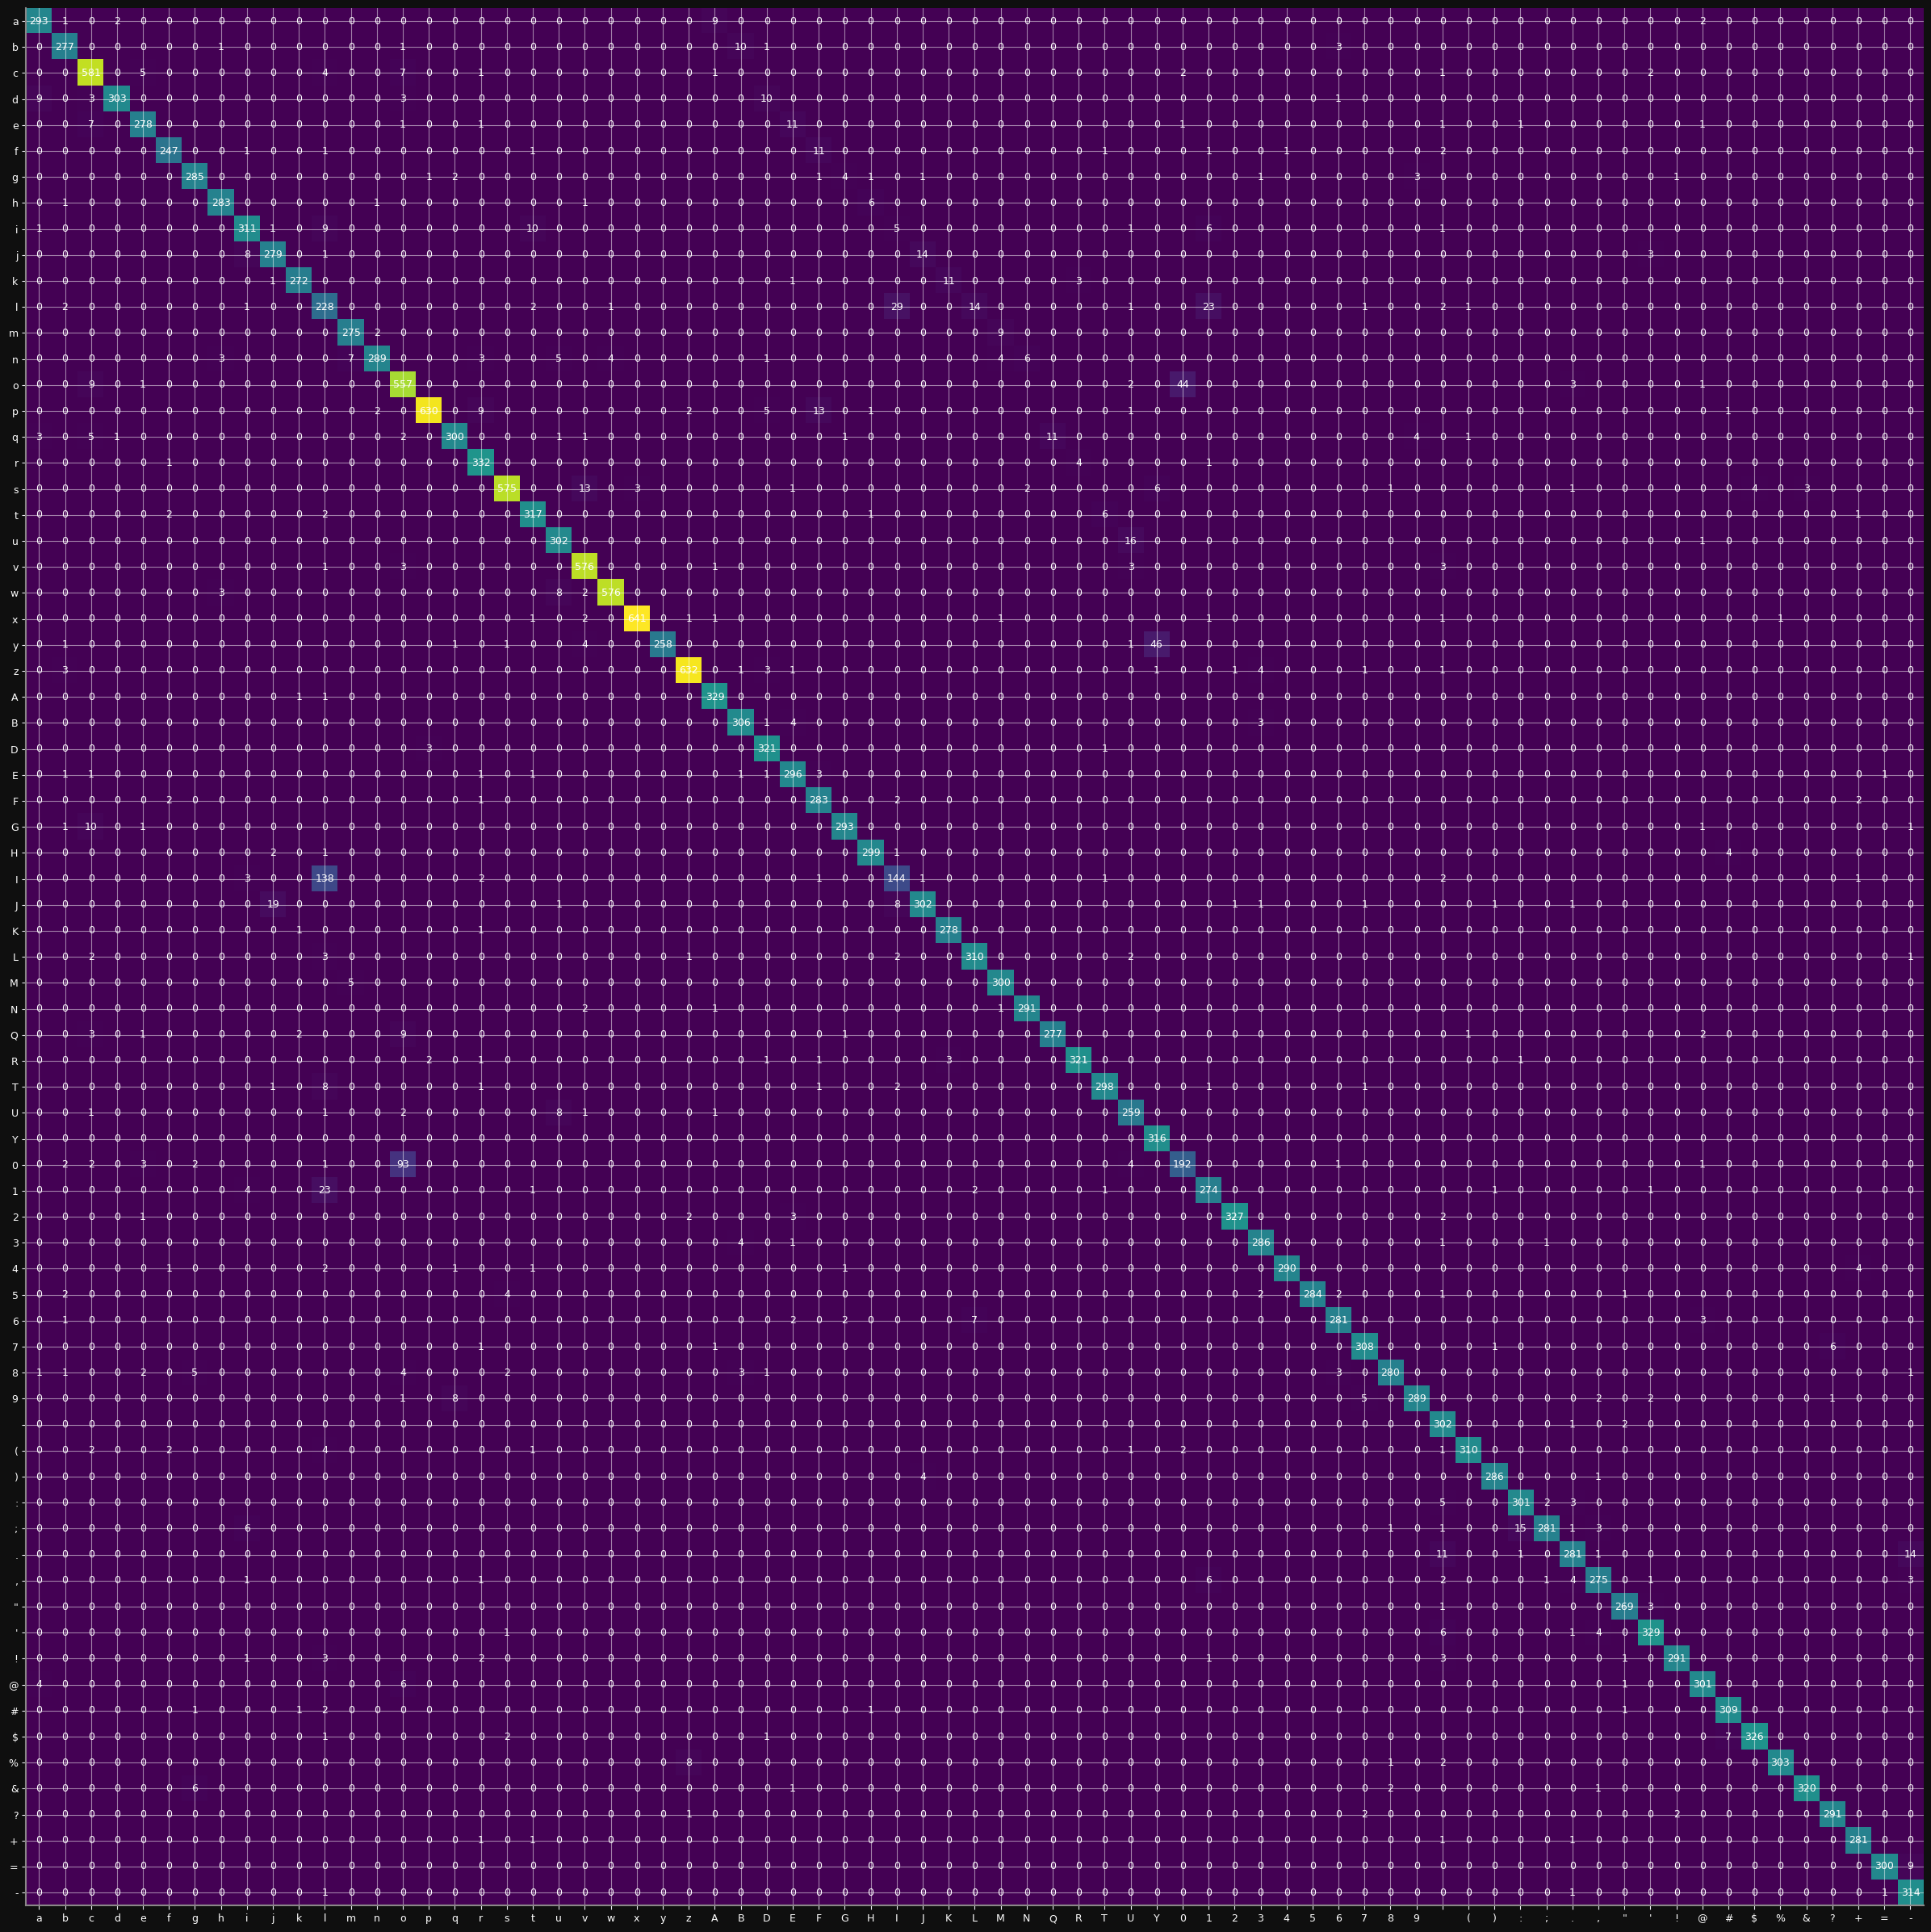

In [13]:
#Data generator and model inspection
tx, ty = dgen.gen_tcls_data(25000, dgen.chars, dgen.evalfonts, False)
predictions = tcls.predict(tx)
guess = [chars[predictions[i].argmax()] for i in range(len(tx))]
real = [chars[ty[i].argmax()] for i in range(len(ty))]


conf = confusion_matrix(y_true=real, y_pred=guess, labels=dgen.chars_cased)
fig, ax = plt.subplots()
fig.set_size_inches(24, 24)
im = ax.imshow(conf)
ax.set_xticks(np.arange(len(dgen.chars_cased)), labels=list(dgen.chars_cased))
ax.set_yticks(np.arange(len(dgen.chars_cased)), labels=list(dgen.chars_cased))
for i in range(len(dgen.chars_cased)):
    for j in range(len(dgen.chars_cased)):
        text = ax.text(j, i, conf[i, j], ha='center', va='center', color='w')
fig.tight_layout()
plt.show()